# Data Literacy Project – Analyzing the Similarity of Covid-19 Time Series Pattern
University of Tuebingen, Winter Term 2021/2022
#### Xuanhao Cao, Dorothee Sigg

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
from iso3166 import countries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import tslearn.clustering as tsc
from tslearn.utils import to_time_series_dataset
from tslearn.metrics import dtw, soft_dtw, dtw_path
from math import floor, ceil, prod
from tslearn.barycenters import \
    euclidean_barycenter, \
    dtw_barycenter_averaging
import folium

In [43]:
# load covid data per country: weekly cases per million

url_wcpm = 'https://github.com/owid/covid-19-data/raw/master/public/data/jhu/weekly_cases_per_million.csv'
weekly_cases_full = pd.read_csv(url_wcpm)

#url_tdpm = 'https://github.com/owid/covid-19-data/raw/master/public/data/jhu/total_deaths_per_million.csv'
#total_deaths_per_million = pd.read_csv(url_tdpm)

# Inspect first few rows of the data
print('Number of rows (=days) in the dataframe: ', len(weekly_cases_full))
print('Number of columns (=countries) in the dataframe: ', len(weekly_cases_full.columns))
weekly_cases_full.head()

Number of rows (=days) in the dataframe:  746
Number of columns (=countries) in the dataframe:  230


,date,World,Afghanistan,Africa,Albania,Algeria,Andorra,Angola,Anguilla,Antigua and Barbuda,...,Uruguay,Uzbekistan,Vanuatu,Vatican,Venezuela,Vietnam,Wallis and Futuna,Yemen,Zambia,Zimbabwe
0,2020-01-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
# preprocess: remove 'countries', which are not countries (e.g. 'high income')
if 'date' in weekly_cases_full.columns:
    weekly_cases_full = weekly_cases_full.set_index('date')

not_country = []
for col in weekly_cases_full.columns:
    if col not in countries: 
        not_country.append(col)
# print(not_country)
# hand-pick from that list
not_country = ['World', 'Africa', 'Asia', 'Europe', 'European Union', 'High income', 'International', 
               'Lower middle income', 'North America', 'Oceania', 'South America', 'Summer Olympics 2020', 
               'Upper middle income']
# pack into additional dataframe:
data_add = weekly_cases_full[not_country]
data_add = data_add.fillna(0)

weekly_cases = weekly_cases_full.drop(not_country, axis=1)
print('Removed the following columns, because they are not a country:')
print(*not_country, sep = ", ")

Removed the following columns, because they are not a country:
World, Africa, Asia, Europe, European Union, High income, International, Lower middle income, North America, Oceania, South America, Summer Olympics 2020, Upper middle income


Interpolating: Removed 90 NaN values.


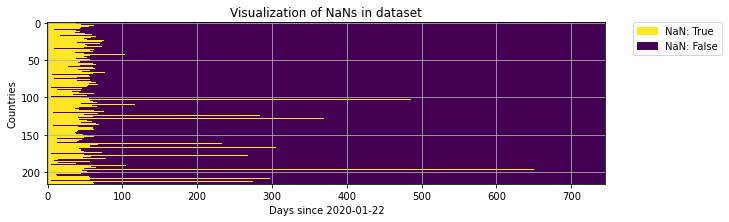

(746, 216)
Removed the following countries, because they have a lot of missing data:
Bonaire Sint Eustatius and Saba, Comoros, Cook Islands, Falkland Islands, Kiribati, Lesotho, Malawi, Marshall Islands, Micronesia (country), Palau, Saint Helena, Saint Pierre and Miquelon, Samoa, Sao Tome and Principe, Solomon Islands, South Sudan, Tajikistan, Tonga, Vanuatu, Wallis and Futuna, Yemen


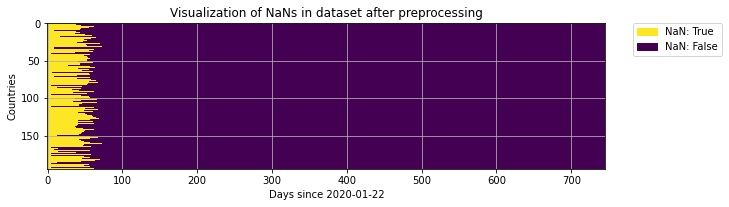

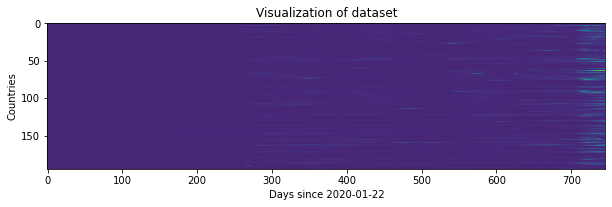

In [45]:
# preprocess: interpolate NaNs in the middle of timeseries
data_interpol = weekly_cases.apply(func=lambda x: x.interpolate())
print('Interpolating: Removed', weekly_cases.isna().sum().sum()-data_interpol.isna().sum().sum(), 'NaN values.')

# find out where the remaining NaNs are located
is_nan = data_interpol.isna()

plt.figure(figsize=(10,14))
im = plt.imshow(is_nan.T, interpolation='none')
colors = [ im.cmap(im.norm(b)) for b in [True, False]]
patches = [ mpatches.Patch(color=colors[i], label="NaN: {l}".format(l=[True, False][i]) ) for i in range(2) ]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
plt.grid(True)
plt.title('Visualization of NaNs in dataset')
plt.xlabel('Days since 2020-01-22')
plt.ylabel('Countries')
plt.show()


# if more than 10% data is missing, country is removed
print(data_interpol.shape)
missing_data_countries = data_interpol.isna().sum()/data_interpol.shape[0] > 0.1
remove_countries = missing_data_countries[missing_data_countries==True]
data_interpol = data_interpol.drop(remove_countries.index, axis=1)
print('Removed the following countries, because they have a lot of missing data:')
print(*remove_countries.index, sep= ", ")

# lets look at NaN visualization again
is_nan = data_interpol.isna()

plt.figure(figsize=(10,14))
im = plt.imshow(is_nan.T, interpolation='none')
colors = [ im.cmap(im.norm(b)) for b in [True, False]]
patches = [ mpatches.Patch(color=colors[i], label="NaN: {l}".format(l=[True, False][i]) ) for i in range(2) ]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
plt.grid(True)
plt.title('Visualization of NaNs in dataset after preprocessing')
plt.xlabel('Days since 2020-01-22')
plt.ylabel('Countries')
plt.show()

# finally, replace NaNs at beginning of the timeseries with 0 
data = data_interpol.fillna(0)

plt.figure(figsize=(10,14))
plt.imshow(data.T)
plt.title('Visualization of dataset')
plt.xlabel('Days since 2020-01-22')
plt.ylabel('Countries')
plt.show()

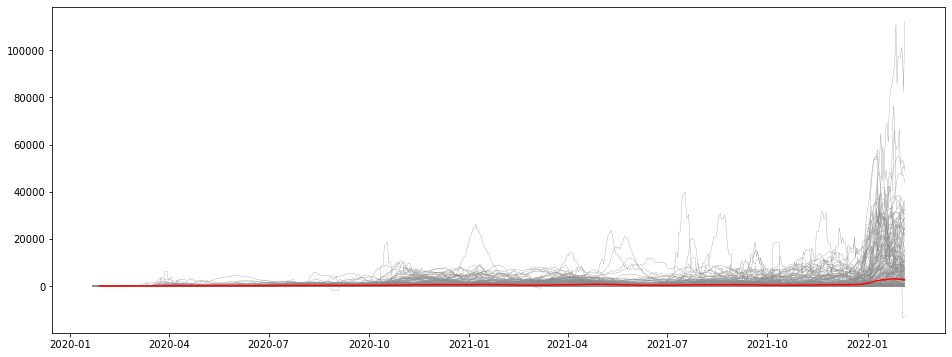

In [6]:
# plotting the cases for each country
dates = pd.to_datetime(data.index)
plt.figure(figsize=(16, 6))
plt.plot(dates, data, linewidth=0.3, color='0.55')
plt.plot(dates, weekly_cases_full['World'], color='r')
plt.show()

Antigua and Barbuda :  -10.129
Benin :  -16.384
Ecuador :  -205.44
Gibraltar :  -237.452
Guyana :  -15.184
Jordan :  -8.277
Kazakhstan :  -416.9
Liberia :  -23.358
Liechtenstein :  -104.564
Luxembourg :  -1910.796
Mauritius :  -22.773
Monaco :  -303.644
Saint Vincent and the Grenadines :  -13552.742
Seychelles :  -30.331
Spain :  -931.882
Uganda :  -0.615
Zimbabwe :  -0.398
['Antigua and Barbuda', 'Benin', 'Ecuador', 'Gibraltar', 'Guyana', 'Jordan', 'Kazakhstan', 'Liberia', 'Liechtenstein', 'Luxembourg', 'Mauritius', 'Monaco', 'Saint Vincent and the Grenadines', 'Seychelles', 'Spain', 'Uganda', 'Zimbabwe']


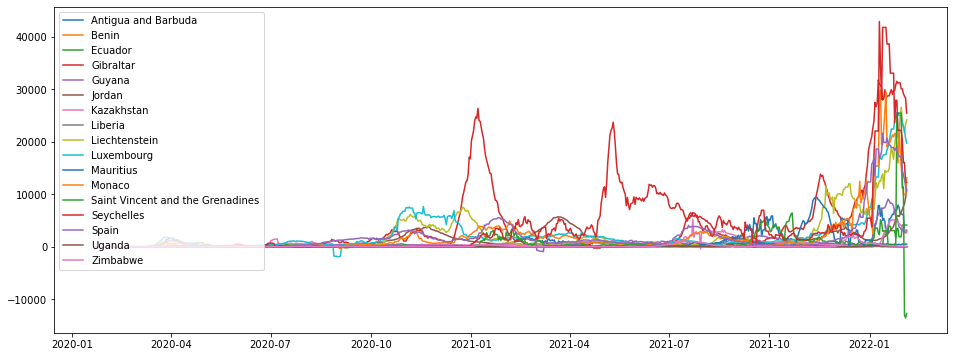

In [7]:
# from the plot we can see that there are some numbers below zero, which should not be the case for incidences
below_zero_countries = []
for c in data.columns:
    if min(data[c]) < 0:
        print(c, ': ', min(data[c]))
        below_zero_countries.append(c)

print(below_zero_countries)

plt.figure(figsize=(16, 6))
for c in below_zero_countries: 
    plt.plot(dates, data[c], label=c)
plt.legend(loc='upper left')   
plt.show()

#### Look at a few single countries

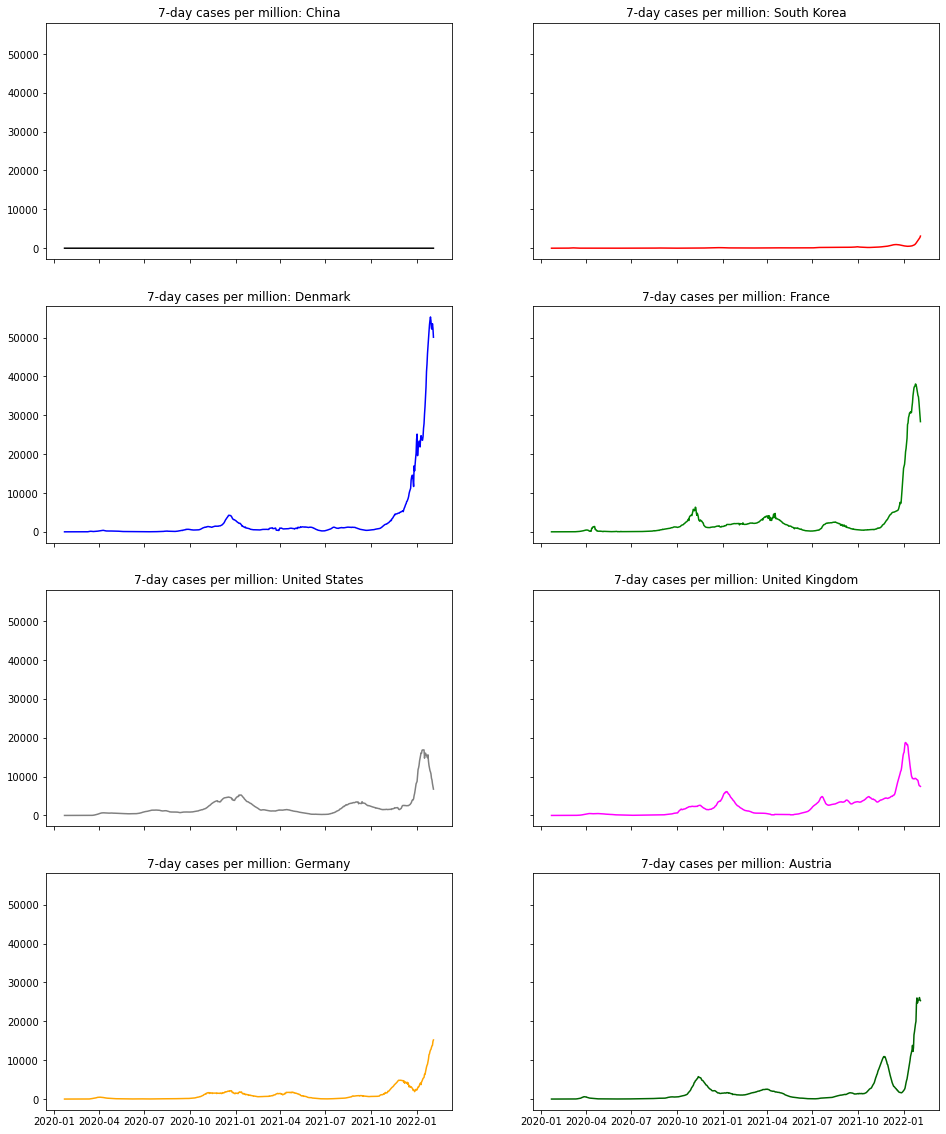

In [9]:
countries = ['China', 'South Korea', 'Denmark', 'France', 'United States', 'United Kingdom', 'Germany', 'Austria']
colors = ['black', 'red', 'blue', 'green', 'grey', 'magenta', 'orange', 'darkgreen']

fig, axs = plt.subplots(ceil(len(countries)/2), 2, sharex=True, sharey=True, figsize=(16, ceil(len(countries)/2)*5))

def axs_pos(x):
    fst = floor(x/2)
    if x % 2 == 0:
        snd = 0
    else:
        snd = 1
    return (fst, snd)

for i in range(len(countries)):
    axs[axs_pos(i)].plot(dates, data[countries[i]], color=colors[i])
    axs[axs_pos(i)].set_title(f'7-day cases per million: {countries[i]}')


In [10]:
similarities_dtw = pd.DataFrame(index=countries, columns=countries)
for c1 in countries:
    for c2 in countries:
        d = dtw(data[c1], data[c2])
        similarities_dtw[c1].loc[c2] = int(d)
print(similarities_dtw)

                 China South Korea Denmark  France United States  \
China                0        9523  239130  191388         97324   
South Korea       9523           0  216827  167538         68169   
Denmark         239130      216827       0   64567        159702   
France          191388      167538   64567       0        105624   
United States    97324       68169  159702  105624             0   
United Kingdom  106645       71832  172791  120080         10768   
Germany          62007       37678  147299   98034         24598   
Austria         114579       89158  101112   49314         55819   

               United Kingdom Germany Austria  
China                  106645   62007  114579  
South Korea             71832   37678   89158  
Denmark                172791  147299  101112  
France                 120080   98034   49314  
United States           10768   24598   55819  
United Kingdom              0   30802   61566  
Germany                 30802       0   41567  
Aus

In [11]:
similarities_eucl = pd.DataFrame(index=countries, columns=countries)

for c1 in countries:
    for c2 in countries:
        d = np.linalg.norm(data[c1]-data[c2])
        similarities_eucl[c1].loc[c2] = int(d)
print(similarities_eucl)

                 China South Korea Denmark  France United States  \
China                0        9533  239134  191417         97350   
South Korea       9533           0  230965  184176         91123   
Denmark         239134      230965       0   79157        170356   
France          191417      184176   79157       0        114202   
United States    97350       91123  170356  114202             0   
United Kingdom  106692       99914  177561  130008         48961   
Germany          62111       53533  185031  141242         61596   
Austria         114672      106706  151028  114573         78211   

               United Kingdom Germany Austria  
China                  106692   62111  114672  
South Korea             99914   53533  106706  
Denmark                177561  185031  151028  
France                 130008  141242  114573  
United States           48961   61596   78211  
United Kingdom              0   75415   93468  
Germany                 75415       0   56818  
Aus

In [11]:
print(similarities_dtw-similarities_eucl)

               China South Korea Denmark  France United States United Kingdom  \
China              0         -10      -4     -29           -26            -47   
South Korea      -10           0  -14138  -16638        -22954         -28082   
Denmark           -4      -14138       0  -14590        -10654          -4770   
France           -29      -16638  -14590       0         -8578          -9928   
United States    -26      -22954  -10654   -8578             0         -38193   
United Kingdom   -47      -28082   -4770   -9928        -38193              0   
Germany         -104      -15855  -37732  -43208        -36998         -44613   
Austria          -93      -17548  -49916  -65259        -22392         -31902   

               Germany Austria  
China             -104     -93  
South Korea     -15855  -17548  
Denmark         -37732  -49916  
France          -43208  -65259  
United States   -36998  -22392  
United Kingdom  -44613  -31902  
Germany              0  -15251  
Austri

Text(0.5, 1.0, 'Time series matching with DTW between Germany and Austria')

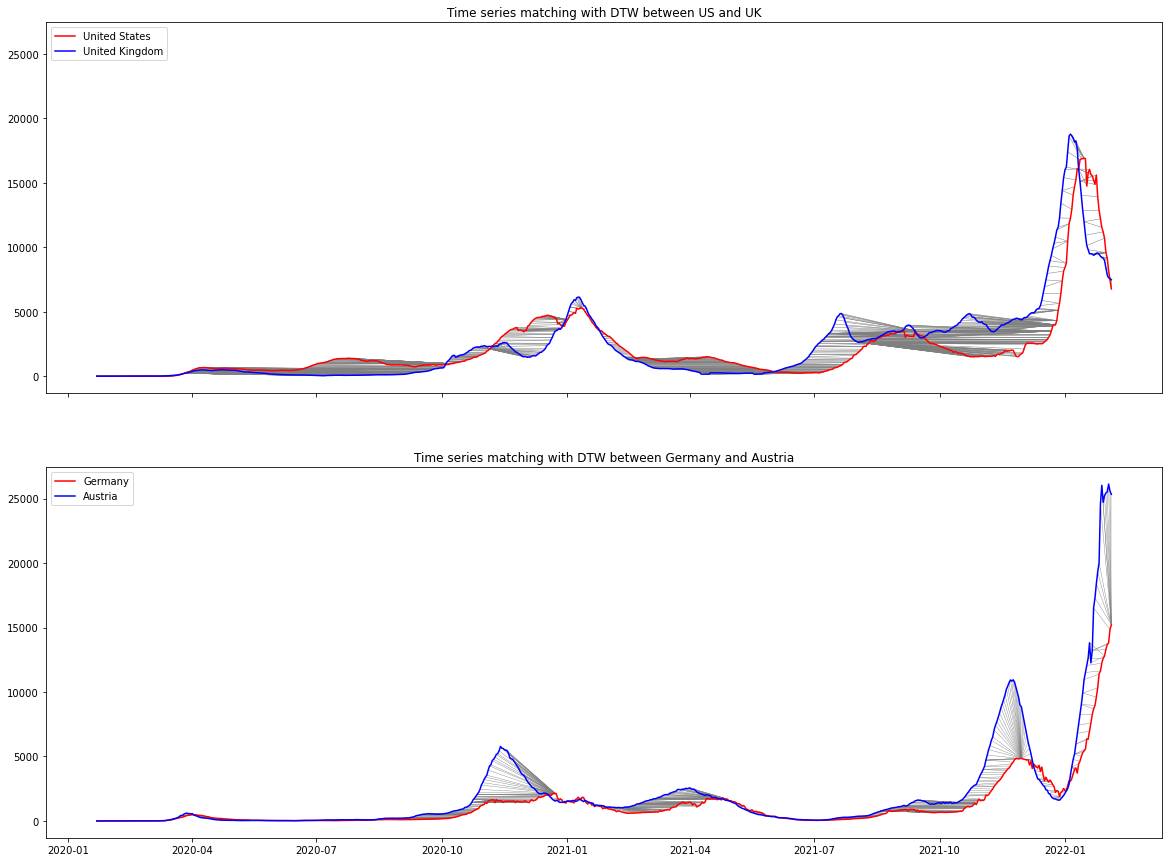

In [12]:
# DTW: lets take United States and United Kingdom as example
us = data['United States']
uk = data['United Kingdom']
ger = data['Germany']
aus = data['Austria']
path_1, dist_1 = dtw_path(us, uk)
path_2, dist_2 = dtw_path(ger, aus)


fig, axs = plt.subplots(2, 1, sharey=True, sharex=True, figsize=(20, 15))
for positions in path_1:
    axs[0].plot([dates[positions[0]], dates[positions[1]]],
                [us.iloc[positions[0]], uk.iloc[positions[1]]], color='grey', linewidth=0.5)
axs[0].plot(dates, us, "r-", label='United States', linewidth=1.5)
axs[0].plot(dates, uk, "b-", label='United Kingdom', linewidth=1.5)
axs[0].legend(loc='upper left')
axs[0].set_title("Time series matching with DTW between US and UK")
    
for positions in path_2:
    axs[1].plot([dates[positions[0]], dates[positions[1]]],
                [ger.iloc[positions[0]], aus.iloc[positions[1]]], color='grey', linewidth=0.4)
axs[1].plot(dates, ger, "r-", label='Germany', linewidth=1.5)
axs[1].plot(dates, aus, "b-", label='Austria', linewidth=1.5)
axs[1].legend(loc='upper left')
axs[1].set_title("Time series matching with DTW between Germany and Austria")


#plt.figure(1, figsize=(8, 8))
#plt.figure(figsize=(20,8))
#plt.plot(dates, us, "b-", label='United States')
#plt.plot(dates, uk, "g-", label='United Kingdom')
#
#for positions in path:
#    plt.plot([dates[positions[0]], dates[positions[1]]],
#             [us.iloc[positions[0]], uk.iloc[positions[1]]], color='grey', linewidth=0.7)
#
#plt.legend()
#plt.title("Time series matching with DTW between US and UK")
#plt.show()

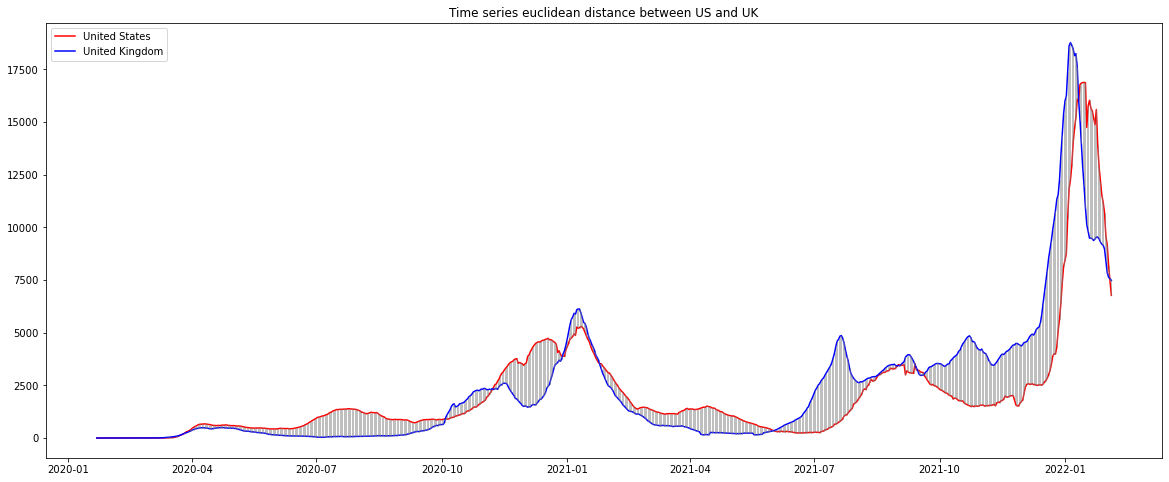

In [13]:
# EUCLIDEAN: lets take United States and United Kingdom as example

#plt.figure(1, figsize=(8, 8))
plt.figure(figsize=(20,8))
plt.plot(dates, us, "r-", label='United States')
plt.plot(dates, uk, "b-", label='United Kingdom')

for positions in range(len(dates)):
    plt.plot([dates[positions], dates[positions]],
             [us.iloc[positions], uk.iloc[positions]], color='grey', linewidth=0.5)

plt.legend()
plt.title("Time series euclidean distance between US and UK")
plt.show()

#### Using TimeSeriesKMeans algorithm

In [17]:
# first use europe countries only

import pycountry_convert as pc

def country_to_continent(country_name):
    country_alpha2 = pc.country_name_to_country_alpha2(country_name)
    country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
    country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
    return country_continent_name

country_continent_dict = {}
for c in data.columns: 
    try:
        country_continent_dict[c] = country_to_continent(c)
    except:
        country_continent_dict[c] = 'undefined'
    
europe_countries = [k for k, v in country_continent_dict.items() if v == 'Europe']
print(len(europe_countries))

data_eu = pd.DataFrame(data[[c for c in data.columns if c in europe_countries]])
data_eu = data_eu.T
print(data_eu.shape)

45
(45, 745)


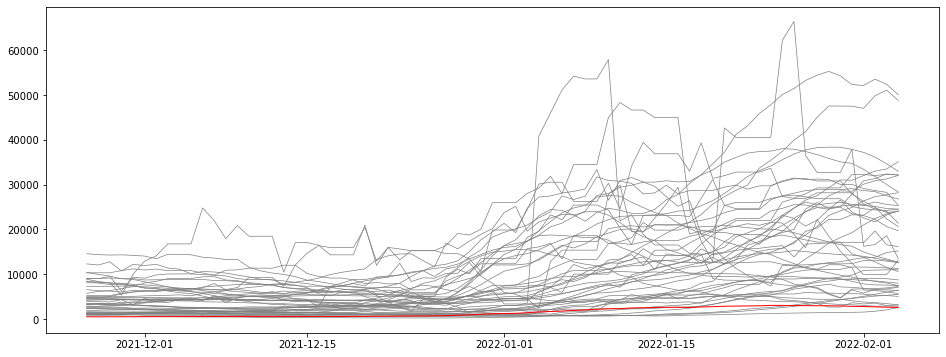

In [18]:
# use only omicron wave (WHO classified omicron as variant of concern from 26. November 2021 onwards)

#print(data.head())
data_omi = data_eu.T['2021-11-26':]

plt.figure(figsize=(16, 6))
plt.plot(pd.to_datetime(data_omi.index), data_omi, color='grey', linewidth=0.7)
plt.plot(pd.to_datetime(data_omi.index), data_add['2021-11-26':]['World'], color='red', linewidth=1)
plt.show()

In [19]:
# from the plot we can see that there is some negative data (which is not possible for incidences)
data_omi.loc[(data_omi<0).any(axis=1)]
dates_omi = pd.to_datetime(data_omi.index)

negative_countries = []

for c in data_omi.columns:
    if min(data_omi[c]) < 0:
        print(c, ': ', min(data_omi[c]))
        negative_countries.append(c)
        
data_omi = data_omi.drop(negative_countries, axis=1)
print(data_omi.shape)

(71, 45)


In [20]:
# continents
data_cont = weekly_cases_full[['Europe', 'Asia', 'Africa', 'North America', 'South America', 'Oceania']]
data_cont = data_cont.fillna(0)
data_cont = data_cont.T
print(data_cont.shape)

(6, 745)


In [21]:
dataset = data_omi.T
dates = dates_omi
print(dataset.shape)

(45, 71)


In [22]:
# iterating over hyperparameter (n_clusters)
# using silhouette score to evaluate clustering
ks = range(2, 20, 1)
m = 'dtw'
scs = []
for k in ks:
    print('Using k =', k, m)
    model = tsc.TimeSeriesKMeans(n_clusters=k, metric=m, max_iter=50)
    labels = model.fit_predict(dataset)
    # print(labels)
    sc = tsc.silhouette_score(dataset, labels, metric=m)
    print('silhouette score:', round(sc, 4))
    scs.append(sc)

best_sc = max(scs)
best_k = ks[scs.index(best_sc)]
print(f'Best clustering: silhouette score = {best_sc}, using k = {best_k}')

Using k = 2 dtw
silhouette score: 0.4869
Using k = 3 dtw
silhouette score: 0.366
Using k = 4 dtw
silhouette score: 0.4966
Using k = 5 dtw
silhouette score: 0.5034
Using k = 6 dtw
silhouette score: 0.5
Using k = 7 dtw
silhouette score: 0.4029
Using k = 8 dtw
silhouette score: 0.4298
Using k = 9 dtw
silhouette score: 0.3609
Using k = 10 dtw
silhouette score: 0.3413
Using k = 11 dtw
silhouette score: 0.3829
Using k = 12 dtw
silhouette score: 0.3166
Using k = 13 dtw
silhouette score: 0.2764
Using k = 14 dtw
silhouette score: 0.3118
Using k = 15 dtw
silhouette score: 0.2981
Using k = 16 dtw
silhouette score: 0.3033
Using k = 17 dtw
silhouette score: 0.2659
Using k = 18 dtw
silhouette score: 0.2494
Using k = 19 dtw
silhouette score: 0.2329
Best clustering: silhouette score = 0.503416986666507, using k = 5


In [24]:
# using time series k-means algorithm
n_clusters = 4
metric = 'dtw'

model = tsc.TimeSeriesKMeans(n_clusters=n_clusters, metric=metric, max_iter=100)
labels = model.fit_predict(dataset)
print(labels)
print(len(labels))


[2 1 1 2 1 2 2 0 1 1 1 2 1 2 1 0 2 1 0 3 0 1 1 1 0 0 2 0 0 1 2 1 2 1 2 2 1
 0 1 1 0 1 1 2 0]
45


In [25]:
# compute silhouette score (-1 for incorrect clustering and +1 for highly dense clustering)
sc = tsc.silhouette_score(dataset, labels, metric=metric)
print('silhouette score:', sc)

silhouette score: 0.44317012211705226


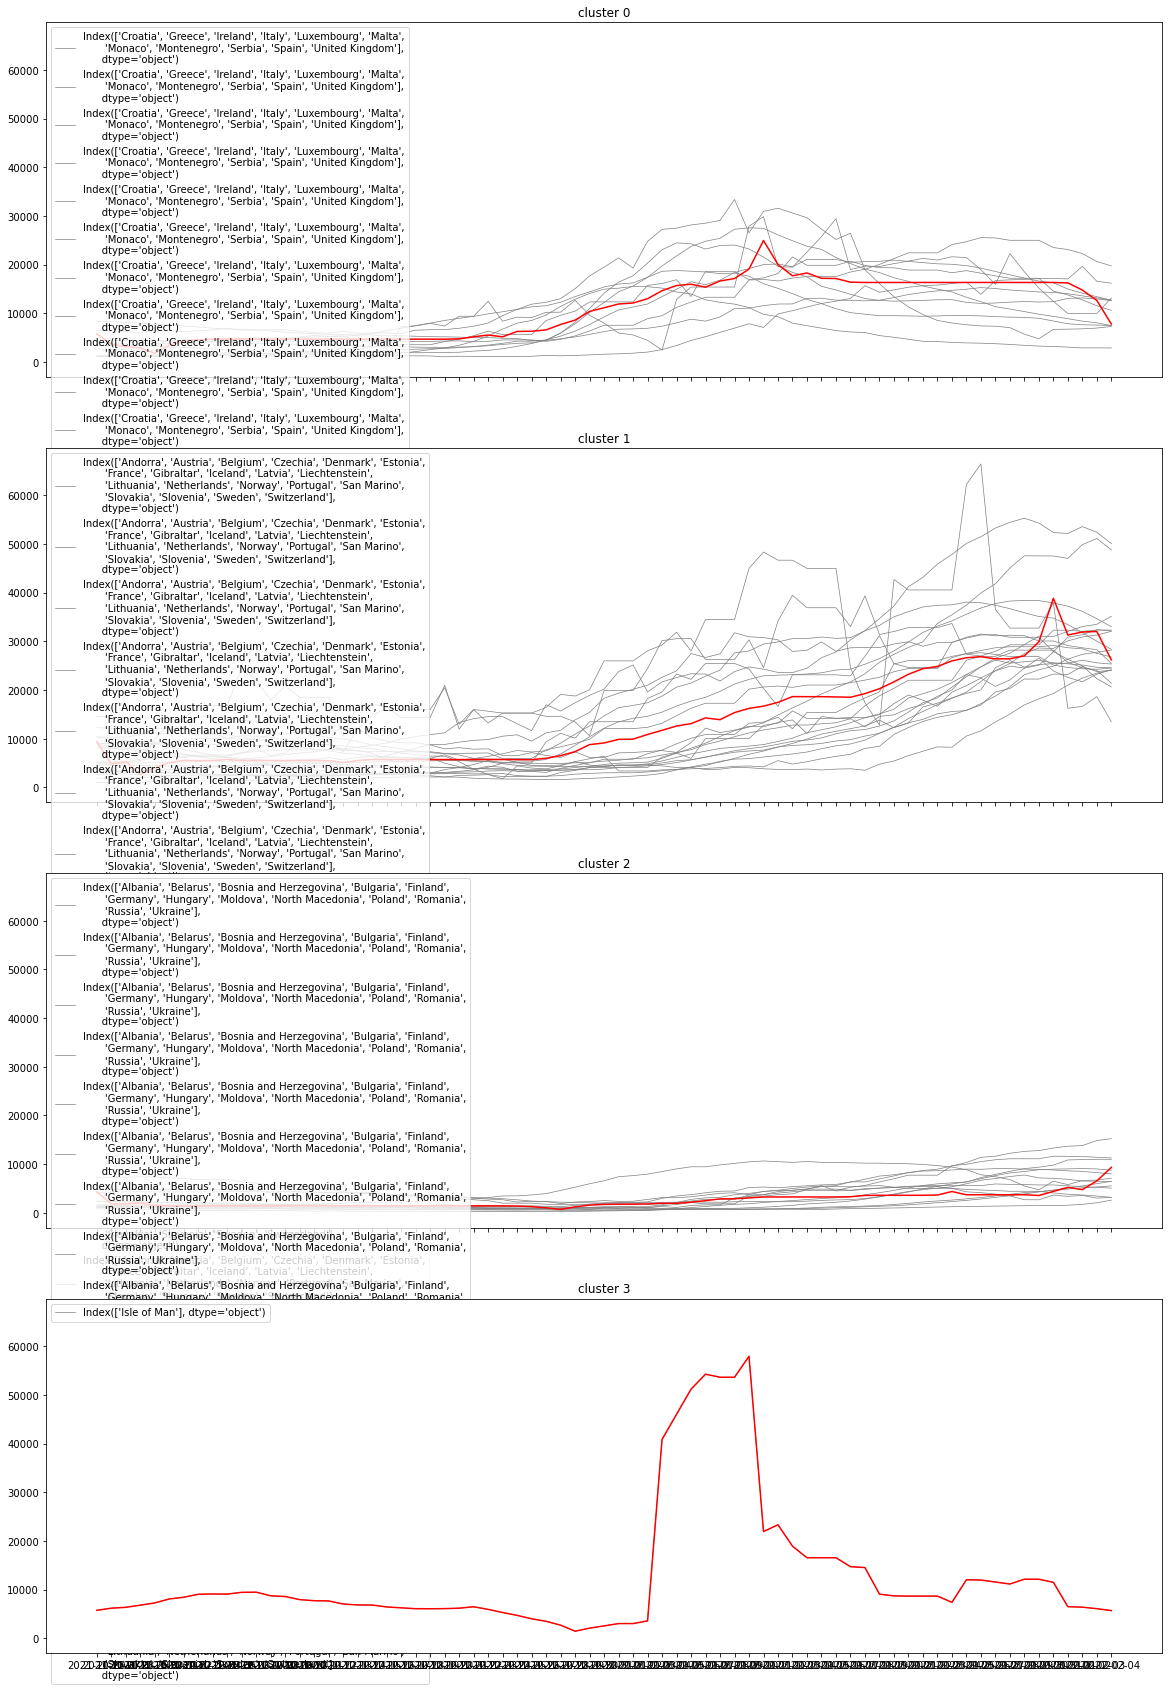

In [42]:
# plot clusterings
fig, axs = plt.subplots(n_clusters, 1, sharex=True, sharey=True, figsize=(20, 30))
centroids = []
for c in range(n_clusters):
    b = [c==label for label in labels]
    axs[c].plot(dataset.iloc[b].T, linewidth=0.7, label = dataset.index[b], color='grey')
    axs[c].set_title(f'cluster {c}')
    axs[c].legend(loc='upper left')
    centroid = dtw_barycenter_averaging(dataset.iloc[b]) #euclidean_barycenter(dataset.iloc[b])
    centroids.append(centroid)
    axs[c].plot(centroid, color='red')


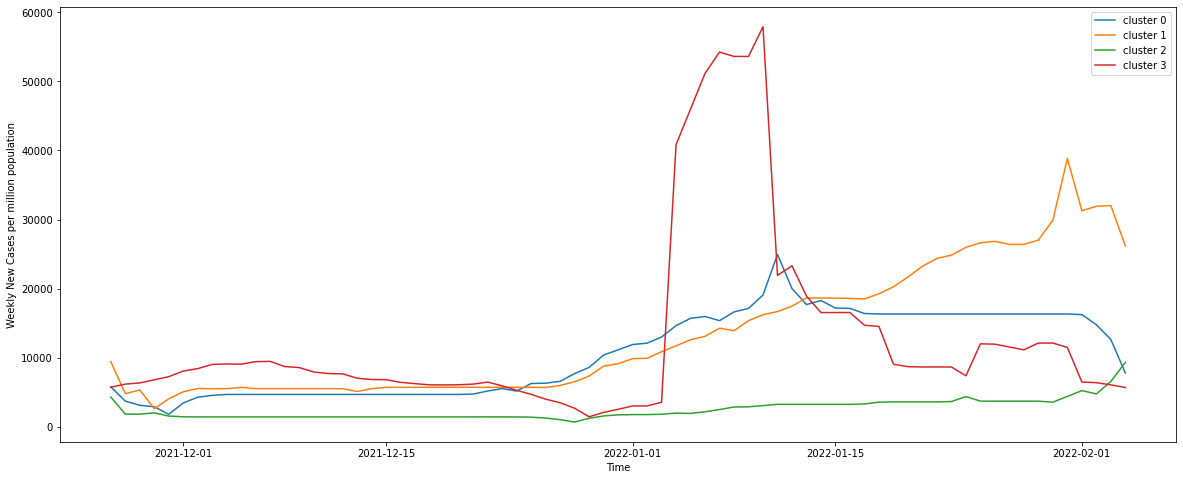

In [40]:
plt.figure(figsize=(20,8)) 
for i in range(len(centroids)): 
    plt.plot(dates, centroids[i], label=f'cluster {i}')
    plt.legend()
plt.xlabel('Time')
plt.ylabel('Weekly New Cases per million population')
plt.show()

In [41]:

country_cluster = pd.DataFrame(zip(dataset.T.columns, labels), 
                               columns=["Country","Cluster"]).sort_values(by="Cluster").set_index("Country")
country_cluster = country_cluster['Cluster'].replace([0, 1, 2, 3, 4], [0, 1, 3, 2, 4])
#print(country_cluster[country_cluster['Cluster'] == 1])
print(len(country_cluster))
print(country_cluster.head())

45
                Cluster
Country                
United Kingdom        0
Ireland               0
Luxembourg            0
Greece                0
Malta                 0


In [35]:
data_for_map = country_cluster.reset_index().replace(['United States','Czechia','Serbia'], 
                                                     ["United States of America",'Czech Republic','Republic of Serbia'])

print(data_for_map.head())

          Country  Cluster
0  United Kingdom        0
1         Ireland        0
2      Luxembourg        0
3          Greece        0
4           Malta        0


In [36]:
# Setup a folium map at a high-level zoom
url3 = 'world-countries.json'
m = folium.Map(zoom_start=4, location=[52,20]) #location=[100, 0],

# choropleth maps bind Pandas Data Frames and json geometries.
#This allows us to quickly visualize data combinations
m.choropleth(geo_data=url3, data=data_for_map,
             columns=['Country', 'Cluster'],
             key_on='feature.properties.name',
             fill_color='YlGnBu', fill_opacity=0.7, line_opacity=0.8,
             nan_fill_color='White',
             bins=n_clusters-1,
#              legend_name=hist_indicator
              )


E:\anaconda\lib\site-packages\folium\folium.py:409: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


In [37]:
m